# STAT301 Project - Final Report
## Dec 5, 2025
## Group 23

### Sarah Chan 56278500, Zewen Jin 71642011, Bryan Sun 39325758, 

## **1 Introduction**

### **1.1 Scientific Question**
I want to examine if the probability of making a purchase is associated with time of the session and the duration of visiting pages related to products.

To answer this question, the model would have variables of interests as below:
- response:`Revenue`
- covariates: `Weekend`, `Month`, `ProductRelated_Duration`

This question is focused on inference, I am exploring if there is a relationship between probability of making a purchase and session time plus duration of visits to product-related pages.

## **2 Methods and Results**

### 2.1.1 Summary of data

The dataset records sessions of online shoppers, where each session belongs to a different user in a 1-year period. There are a total of 12330 sessions(observations) and 18 variables, which are described below:

- `Administrative` (Integer): the number of administrative pages the user visited during a session
- `Administrative_Duration`	(Integer): the total time spent on administrative pages during a session	
- `Informational`	(Integer): the number of informative pages the user visited during a session
- `Informational_Duration`	(Integer): the total time spent on informative pages during a session		
- `ProductRelated`	(Integer): the number of product-related pages the user visited during a session
- `ProductRelated_Duration`	(Continuous): the total time spent on product-related pages during a session	

Note: The values of the above features are derived from the URL information of the pages visited by the user and updated in real time when a user takes an action, e.g. moving from one page to another. **The unit time for the durations are not given**.

- `BounceRates`	(Continuous): the percentage of visitors who enter the site from that page and then leave ("bounce") without triggering any other requests to the analytics server during that session
- `ExitRates`	(Continuous): for all pageviews to a specific page, the percentage of the pageviews that were the last in the session
- `PageValues`	(Integer): the average value for a web page that a user visited before completing an e-commerce transaction
- `SpecialDay`	(Integer): the closeness of the site visiting time to a specific special day, determined by considering the dynamics of e-commerce such as the duration between the order date and delivery date
- `Month`	(Categorical): the month in which the session occurred 
- `OperatingSystems`	(Integer): the type of operating system used for the session (probably encoded into integers here)
- `Browser`	(Integer): the type of browser used for the session (probably encoded into integers here)
- `Region`	(Integer): the region in which the session occurred (probably encoded into integers here)
- `TrafficType`	(Integer): the type of traffic used during the session (probably encoded into integers here)
- `VisitorType`	(Categorical): type of visitor for a page, either a returning (`Returning_visitor`) or new (`New_visitor`)
- `Weekend`	(Binary): whether or not the date of visit to a page is on a weekend	
- `Revenue`	(Binary): whether or not revenue is made, ie. if the user made a purchase	

As shown below, there are **no missing values** in the dataset.

**Data not from region 1 will only be used as instructed.**

### 2.1.2 Source of data

The dataset is obtained from the UC Irvine Machine Learning Repository (https://archive.ics.uci.edu/dataset/468/online+shoppers+purchasing+intention+dataset). The data is obtained from website analytics tools, such as Google Analytics and more, collecting number of page visits, duration of visits, type of visitor, etc.

### 2.1.3 Preselection of variables

I would exclude the variables `OperatingSystems`, `Browser`, `Region`, `TrafficType` because they are already encoded into integers without a description of what each integer represents, causing lack of interpretation of these variables and the inability to make meaningful insights for these variables.

### **2.2 Exploratory Data Analysis**

The dataset is loaded in using `read.csv()` and the excluded variables are removed first using `select()`. 

The data type is checked, and I also checked if there are any missing values.

<!-- install.packages("ggpubr")
install.packages("corrplot")
install.packages("broom")
install.packages("car") -->

In [1]:
# install.packages("ggpubr")


In [2]:
library(dplyr, warn.conflicts = FALSE)
library(ggplot2, warn.conflicts = FALSE)
library(ggpubr, warn.conflicts = FALSE)
library(corrplot, warn.conflicts = FALSE)
library(car, warn.conflicts = FALSE)
library(broom, warn.conflicts = FALSE)

corrplot 0.95 loaded

Loading required package: carData



In [3]:
data <- read.csv("data/online_shoppers_intention.csv")

data <- data %>% filter(Region != 1) # Use data not from Region 1
data <- data %>% select(-OperatingSystems, -Browser, -Region, - TrafficType) # Remove the excluded variables listed in section 1.3

head(data)

,Administrative,Administrative_Duration,Informational,Informational_Duration,ProductRelated,ProductRelated_Duration,BounceRates,ExitRates,PageValues,SpecialDay,Month,VisitorType,Weekend,Revenue
,<int>,<dbl>,<int>,<dbl>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<lgl>,<lgl>
1,0,0,0,0,1,0.000000,0.20000,0.20000000,0,0.0,Feb,Returning_Visitor,FALSE,FALSE
2,0,0,0,0,2,2.666667,0.05000,0.14000000,0,0.0,Feb,Returning_Visitor,FALSE,FALSE
3,0,0,0,0,1,0.000000,0.20000,0.20000000,0,0.4,Feb,Returning_Visitor,FALSE,FALSE
4,0,0,0,0,2,37.000000,0.00000,0.10000000,0,0.8,Feb,Returning_Visitor,FALSE,FALSE
5,0,0,0,0,3,395.000000,0.00000,0.06666667,0,0.0,Feb,Returning_Visitor,FALSE,FALSE
6,0,0,0,0,16,407.750000,0.01875,0.02583333,0,0.4,Feb,Returning_Visitor,FALSE,FALSE


In [4]:
# check data type of each variable
sapply(data, class)

# check for missing values count in data frame
sum(is.na(data))

Administrative Administrative_Duration           Informational 
              "integer"               "numeric"               "integer" 
 Informational_Duration          ProductRelated ProductRelated_Duration 
              "numeric"               "integer"               "numeric" 
            BounceRates               ExitRates              PageValues 
              "numeric"               "numeric"               "numeric" 
             SpecialDay                   Month             VisitorType 
              "numeric"             "character"             "character" 
                Weekend                 Revenue 
              "logical"               "logical"

[1] 0

There is nothing wrong about the data types, and no missing values present in the dataset.

Here are the summary statistics for each variables:

In [5]:
summary(data)
# count of observations for each category for the categorical variables
data %>% count(Month)
data %>% count(VisitorType)

 Administrative   Administrative_Duration Informational    
 Min.   : 0.000   Min.   :   0.00         Min.   : 0.0000  
 1st Qu.: 0.000   1st Qu.:   0.00         1st Qu.: 0.0000  
 Median : 1.000   Median :  10.00         Median : 0.0000  
 Mean   : 2.343   Mean   :  81.56         Mean   : 0.4771  
 3rd Qu.: 4.000   3rd Qu.:  97.46         3rd Qu.: 0.0000  
 Max.   :27.000   Max.   :2156.17         Max.   :14.0000  
 Informational_Duration ProductRelated   ProductRelated_Duration
 Min.   :   0.00        Min.   :  0.00   Min.   :    0.0        
 1st Qu.:   0.00        1st Qu.:  7.00   1st Qu.:  189.8        
 Median :   0.00        Median : 18.00   Median :  603.1        
 Mean   :  32.69        Mean   : 30.42   Mean   : 1143.2        
 3rd Qu.:   0.00        3rd Qu.: 37.00   3rd Qu.: 1448.9        
 Max.   :2252.03        Max.   :584.00   Max.   :24844.2        
  BounceRates         ExitRates         PageValues        SpecialDay     
 Min.   :0.000000   Min.   :0.00000   Min.   :  0.0

Month,n
<chr>,<int>
Aug,276
Dec,1101
Feb,99
Jul,284
June,188
Mar,1129
May,2137
Nov,1710
Oct,334


VisitorType,n
<chr>,<int>
New_Visitor,1037
Other,77
Returning_Visitor,6436


Interestingly, there are no sessions recorded in January or April.

There are also another type of visitor that is not included in data description values.

There could be extreme outliers for the duration of page visits (`Administrative_Duration`, `Informational_Duration`,`ProductRelated_Duration`), seen by comparing the median and the max of these variables

`summarise()` has grouped output by 'Month'. You can override using the `.groups` argument.


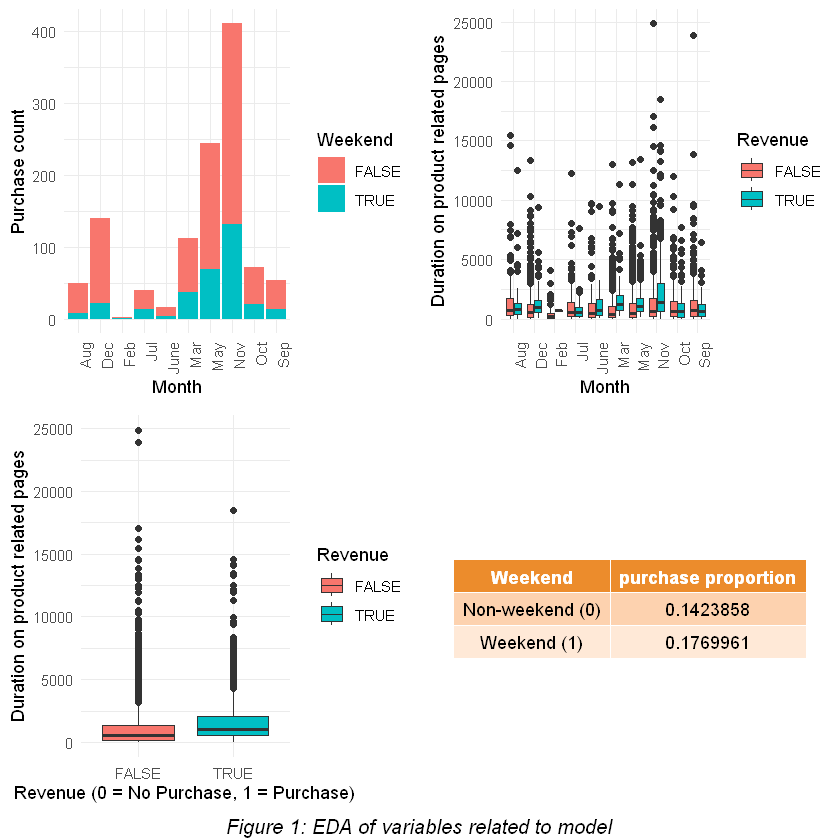

In [6]:
# Plot of Revenue against Month and ProductRelated_Duration
rev_month_dur <- ggplot(data, aes(x = Month, y = ProductRelated_Duration)) +
  geom_boxplot(aes(fill = Revenue)) +
  labs(
    x = "Month",
    y = "Duration on product related pages"
  ) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))

# Plot of Revenue against Month and Weekend
rev_month_we_sum <- data %>%
  group_by(Month, Weekend) %>%
  summarize(count = sum(Revenue)) 

rev_month_we <- ggplot(rev_month_we_sum, aes(x = Month, y = count, fill=Weekend)) +
  geom_bar(stat="identity",position="stack") +
  labs(
    x = "Month",
    y = "Purchase count",
  ) +
  theme_minimal()+
  theme(axis.text.x = element_text(angle = 90, hjust = 1)) 

# Table of Revenue against Weekend using proportion of successful purchases
weekend_sum <- data %>%
  group_by(Weekend) %>%
  summarize("purchase proportion" = mean(Revenue)) %>%
  mutate(Weekend = if_else(Weekend == 0, "Non-weekend (0)", "Weekend (1)"))
weekend_table <- ggtexttable(weekend_sum, rows = NULL, 
                        theme = ttheme("mOrange"))


# Plot of Revenue against ProductRelated_Duration
rev_dur <- ggplot(data, aes(x = Revenue, y = ProductRelated_Duration)) +
  geom_boxplot(aes(fill=Revenue)) +
  labs(
    x = "Revenue (0 = No Purchase, 1 = Purchase)",
    y = "Duration on product related pages",
  ) +
  theme_minimal()

# combine above plots into one plot using ggarrange from ggpubr library
plot <- ggarrange(rev_month_we, rev_month_dur, rev_dur,  weekend_table , 
          ncol = 2, nrow = 2)
annotate_figure(plot,
                bottom = text_grob("Figure 1: EDA of variables related to model", 
                                   color = "black", face = "italic", size = 12))

*Remark: I used proportion of purchases for visualizing the relationship between `Weekend` and `Revenue` because there are imbalance of number of days for weekend and non-weekend (2 days and 5 days respectively, which would give misleading results if I simply plot the raw counts).*

From Figure 1:

- I believe this plot is relevant to my question because it shows exploration of the potential relationships between the covariates (or interaction of covariates) and the response variable. Visualizing the variables could help with making an initial identification of which covariates are associated with probability of making a purchase.
- > ***The first plot in the figure shows that the number of purchases in December, March, May, and November is much higher compared to other months. In addition, the second plot shows that the duration on product-related pages for succussful purchases is noticeably higher in November and March compared to other months. Therefore, these two plots suggests that the probability of making a purchase could  vary across each month.***
- From the visualization, I can see that there are extreme outliers for `ProductRelated_Duration`, which could impair our model as these could greatly influence the linear model. Moreover, there is very little data for the revenue count in February, so the estimates in the model for February may be unreliable or biased. 

### **2.3 Methods: Plan**

I will use **logistic regression** because my research question is about understanding the relationship between online purchases and session features. The repsonse variable `revenue` is a binary variable, so this method is appropraiate for this context since it can map probability of successful online purchases to binary outcomes, and the probability is dependent on session features. Moreover, logistic regression allows for interpretable coefficient estimates in terms of likelihood or probabilities of successful online purchases.

**Assumptions**: 
Logistic regression assumes that the observations are independent, the response is binary, and that the log-odds of online purchases has a linear relationship with the session features. It also assumes that there is no multicollinearity issue between the covariates. 

**Limitations**:
This model cannot capture non-linear relationships between log-odds of online purchases and session features unless data transformation or interaction terms is introduced. It is also sensitive to outliers. In addition, if the observations are not independent or multicollinearity is present, the standard errors would be inflated, which would lead to unreliable p-values so that statistical inference are invalid.

### **2.4 Computational Code and Results**

For valid inferemce, I will fit the logistic regression model with all session features to control for potential confounding effects.

However, some variables are first removed due to redundancy and multicollinearity issues. As stated in section 1.3, `OperatingSystems`, `Browser`, `Region`, `TrafficType` are excluded already since their values do not have meaningful descriptions. Only data not from region 1 is used as well.  

Potential correlated numeric covariates is first explored, I will use 0.6 as a threshold:

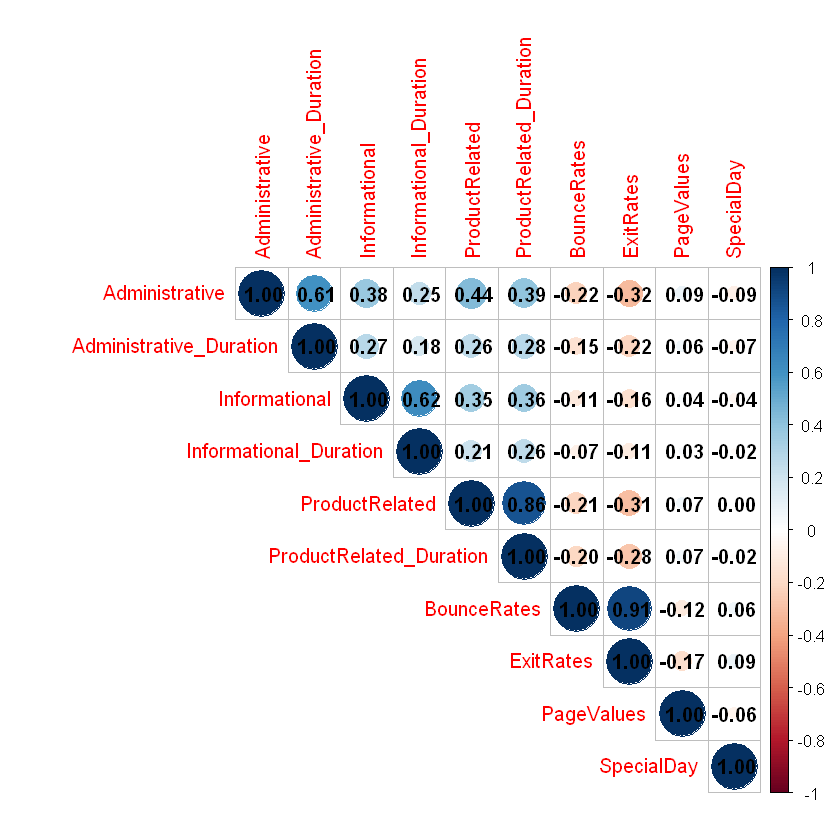

In [7]:
# plotting the correlation plot for numeric variables
numeric_data <- data[sapply(data, is.numeric)]
cor_mat <- cor(numeric_data, use = "complete.obs")

corrplot(cor_mat,
         type = "upper",       
         addCoef.col = "black" 
)

From the correlation plot, it can be seen that `BounceRates` and `ExitRates`, `ProductRelated` and `ProductRelated_Duration`, `Informational` and `Informational_Duration`, `Administrative` and `Administrative_Duration`, all have correlation more than 0.6. 

Therefore, I would remove the variables `BounceRates` since it's less informative than `ExitRates` (reflects end-of-session behavior of shoppers), and `ProductRelated`, `Informational`, `Administrative` as these variables are counts of pages visited, which is less interpretable than time spent. 

After removing the correlated variables, I changed the categorical variables into factor types for model fitting. The model is then fitted on the remaining variables and multicollinearity issues is checked.

In [8]:
# Remove the correlated variables
uncor_data <- data %>% select(-BounceRates, -ProductRelated, -Informational, -Administrative)

# Change categorical variables to factor type
uncor_data$Month <- as.factor(uncor_data$Month)
uncor_data$VisitorType <- as.factor(uncor_data$VisitorType)

# fit 1st model
model <- glm(Revenue ~ ., uncor_data, family = "binomial")

# check vif for multicollinearity issue
vif(model)

,GVIF,Df,GVIF^(1/(2*Df))
Administrative_Duration,1.106027,1,1.051678
Informational_Duration,1.080315,1,1.039382
ProductRelated_Duration,1.225330,1,1.106946
ExitRates,1.130968,1,1.063470
PageValues,1.057583,1,1.028388
SpecialDay,1.228721,1,1.108477
Month,1.335842,9,1.016217
VisitorType,1.140461,2,1.033404
Weekend,1.014770,1,1.007358


The VIF of each variable is less than 5, so there is no sign of multicollinearity issues. Statistical inference can now be performed.

In [10]:
# Get estimates and p-values
model %>% tidy(exponentiate=T) %>%
    mutate_if(is.numeric, round, 3)

term,estimate,std.error,statistic,p.value
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
(Intercept),1.868181e-01,2.169188e-01,-7.7338608,1.043331e-14
Administrative_Duration,1.000097e+00,2.132418e-04,0.4550787,6.490526e-01
Informational_Duration,1.000333e+00,2.329976e-04,1.4295134,1.528567e-01
ProductRelated_Duration,1.000099e+00,2.065717e-05,4.8073303,1.529592e-06
ExitRates,5.885775e-08,2.054779e+00,-8.1021563,5.399349e-16
PageValues,1.087379e+00,3.154714e-03,26.5539551,2.311835e-155
SpecialDay,7.772795e-01,2.972488e-01,-0.8476241,3.966473e-01
MonthDec,5.452386e-01,2.252291e-01,-2.6929548,7.082187e-03
MonthFeb,2.198506e-01,7.768502e-01,-1.9499347,5.118390e-02


***Only the above table is used to report results.***

**Interpretation:**

The interpretations below are given at the 5% significance level:

The results shows that `Weekend`, `ProductRelated_Duration`, and certain months (December, March, May, and November) have a statistically significant effect on the odds of online purchase (p-value < 0.05). The odds of an online purchase for weekend sessions increases by a factor of 1.202 **compared to weekday sessions**; and holding all other covariates in the model constant at any value, an increase of 1 unit time in the duration on product-related pages is associated with an increase by a factor of 1.000 in the odds of online purchase (this is rounded, so it slightly increases the odds). The months with a significant effect will change the odds of online purchase **compared to August**, and this could reflect seasonal patterns. These results confirm that these session features have a statistically significant effect on the probability of purchase, addressing my question of interest.

<!-- `Weekend` is statistically significant (p-value < 0.05). Holding all other covariates in the model constant at any value, the odds of an online purchase for weekend sessions increases by a factor of 1.202 compared to weekday sessions.

`ProductRelated_Duration` is statistically significant (p-value < 0.05). Holding all other covariates in the model constant at any value, an increase of 1 unit time in the duration on product-related pages is associated with an increase by a factor of 1.000 in the odds of online purchase.

The model includes the variable `Month` with January as the base reference. Holding all other covariates in the model constant at any value, each estimated coefficient shows the change in odds of an online purchase for that month compared to January. 
- For instance, holding all other covariates in the model constant at any value, the odds of an online purchase in November increases by a factor of 1.570 compared to January.
- Based on the p-value, it can be seen that the months December, March, May, November have a statistically significant effect on the odds of an online purchase compared to January, holding all other covariates in the model constant at any value.
 -->

In [ ]:
# 2nd model: simple model y ~ month + weekend + productrealted_duration

#  3nd model: simple model y ~ month * weekend * productrealted_duration

In [ ]:
# compare models using anova

In [ ]:
# pick the best model, run diagnostic plots using plot(model)